# Points-of-interest

This notebook was created to iteratively determine which pixels of the sea ice indicator data product should be used for analysis of some chosen points-of-interest. The code here highlights the pixels selected to represent the chosen locations and produces the coordinates in EPSG:3411, which are written to `$BASE_DIR/ancillary/points_of_interest.csv`. This notebook is included in `manuscript_content/` because it is part of the analysis for the manuscript, with the aforementioned CSV containing coordinates that are necessary for creating some of the figures. 

Because the code used here is not too complex, it is all included in this notebook, instead of in separate scripts. The cells in this notebook are meant to be executed sequentially, they are not set up to be run independently.

In [81]:
def reproject_poi(poi, in_epsg=4326, out_epsg=3411):
    """Reproject WGS84 coordinates

    Args:
        poi (list/tuple): 2-tuple or 2 item list of
            coordinates of point to reproject in (<lat>, <lon>) format
        in_epsg (int): EPSG code of coords
        out_epsg (int): EPSG to reproject to

    Returns:
        tuple of x, y coordinates in out_epsg, formatted as (<x>, <y>)
    """
    transformer = Transformer.from_crs(in_epsg, out_epsg)

    return transformer.transform(*poi)


def get_offsets_xy(src, xy, offsets):
    """
    returns list of center points of pixels corresponding
    to the offsets
    """
    row, col = src.index(*xy)

    return [src.xy(row + offset[0], col + offset[1]) for offset in offsets]


def get_xy_lims(x, y, scale):
    """Get the x, y limits for a point given the scale specified in the dict"""
    xlims = (x - scale * 1e5, x + scale * 1e5)
    ylims = (y - scale * 1e5, y + scale * 1e5)

    return xlims, ylims


def clip_shore_to_viewing_extent(world_shore, xlims, ylims):
    """Clip the shore polygon to the extent derived from the xy lims"""
    corner_list = [
        (xlims[0], ylims[0]),
        (xlims[0], ylims[1]),
        (xlims[1], ylims[1]),
        (xlims[1], ylims[0]),
        (xlims[0], ylims[0]),
    ]
    bb = Polygon([corner for corner in corner_list])
    bb_df = gpd.GeoDataFrame(geometry=[bb]).set_crs(3411)
    
    return gpd.overlay(bb_df, world_shore, how="intersection")
    

def make_pixel_polygon_from_xy(transform, x, y):
    """Make polygon corresponding to raster pixels
    from given xy centerpoint and the raster's Affine transform
    """
    res = transform[0]
    ul = (x - (res / 2), y + (res / 2))
    corner_list = [
        ul,
        (ul[0] + res, ul[1]),
        (ul[0] + res, ul[1] - res),
        (ul[0], ul[1] - res),
        ul,
    ]
    
    return Polygon([corner for corner in corner_list])


def make_pixel_poly_gdf(transform, xy_list):
    """make GeoPandas DF of pixel polygons from xy list and transform"""
    polys = [make_pixel_polygon_from_xy(transform, *xy) for xy in xy_list]

    return gpd.GeoDataFrame(geometry=polys)


def plot_poi_pixel_polys(poi, offsets, scale, seamask_src, world_shore, coast_src=None):
    """Plot the polygons depicting the pixels to be used for the points of interest

    Args:
        poi (tuple): lat/lon coordinates in form (lat, lon)
        offsets (list): list of 2-tuples with offset values for pixels to inclue in analysis
        scale (float): scalar multiplier to determine viewing window
        seamask_src (rasterio.io.DatasetReader): Open GeoTIFF of seamask for basemap
        coast_src (rasterio.io.DatasetReader): Open GeoTIFF of coast antimask to show coastal pixels
        world_shore (GeoPandas.GeoDataFrame): polyons for shoreline boundaries
        

    Returns:
        list of coordinates of pixels corresponding to offsets
    """
    # coordinates of point of interest
    poi_xy = reproject_poi(poi)
    # list of coordinates of pixels corresponding to offsets from 
    #   pixel overlapping POI
    xy_list = get_offsets_xy(seamask_src, poi_xy, offsets)
    # get x and y limits for viewing window based on 
    #   scale and poi_xy
    xlims = (poi_xy[0] - scale * 1e5, poi_xy[0] + scale * 1e5)
    ylims = (poi_xy[1] - scale * 1e5, poi_xy[1] + scale * 1e5)
    
    # get polygon of shoreline within viewing window
    shore_poly = clip_shore_to_viewing_extent(world_shore, xlims, ylims)
    
    # make pixel polygons
    pixel_polys = make_pixel_poly_gdf(seamask_src.transform, xy_list)

    # create plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    # plot basemap
    show(seamask_src, ax=ax, vmax=10000, cmap="twilight")
    # plot coastline pixels
    if coast_src is not None:
        show(coast_src, ax=ax, interpolation="none")
    # plot shorelines
    shore_poly.plot(ax=ax, facecolor="none", edgecolor="gray")
    # plot cells that will be used
    pixel_polys.plot(ax=ax, facecolor="none", edgecolor="red")
    # show the point of interest
    ax.scatter(*poi_xy, color="red")
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)

    return xy_list


def plot_date_histograms(fubu, xy_list):
    """Summarize the counts of years for which the indicators were defined
    in a bar chart
    """
    # initialize index for DF
    index = []
    
    # make names for each of the offset pixels
    offset_names = [f"p{i}" for i in range(len(xy_list))]
    # initialize dict for DF
    df_di = {name: [] for name in offset_names}
    df_di["indicator"] = []
    
    for indicator in list(fubu.variables)[:4]:
        for xy, name in zip(xy_list, offset_names):
            dates = fubu[indicator].sel(xc=xy[0], yc=xy[1], method="nearest").values.astype(np.float32)
            dates[dates == -9999] = np.nan
            df_di[name].extend(dates)
        df_di["indicator"].extend(np.repeat(indicator, len(dates)))
        
    df = pd.DataFrame(df_di)
    df.hist(by="indicator", figsize=(15, 4), layout=(1, 4))
    plt.tight_layout()
    
    # compute mean indicator dates for point extraction
    df["mean_date"] = np.round(df.drop(columns="indicator").mean(axis=1), 1)
    df["location"] = poi_name
    df["year"] = np.tile(fubu.year.values, 4)
    
    return df[["year", "location", "indicator", "mean_date"]]

### GSHHG world shoreline

For use here and in map-based figures of the manuscript content.

In [3]:
# User parameters
# set clobber to True to download even if GSHHG 
#   dataset exists locally.
clobber = False

terminal_output = open("/dev/stdout", "w")


import os
import zipfile
from pathlib import Path
import geopandas as gpd
from download_ancillary import run_download

def download_extract_gshhg():
    print("Downloading GSHHG world shoreline dataset", file=terminal_output, flush=True)
    run_download(gshhg_url, gshhg_zip_fp)
    print(f"GSHHG world shoreline dataset written to {gshhg_zip_fp}", file=terminal_output, flush=True)

    # unzip the downloaded shoreline dataset
    print("Extracting the downloaded GSHHG data...", file=terminal_output, flush=True)
    with zipfile.ZipFile(gshhg_zip_fp, "r") as zip_ref:
        zip_ref.extractall(gshhg_dir)
    print(f"GSHHG world shoreline download extracted to {gshhg_dir}", file=terminal_output, flush=True)
    
    return

scratch_dir = Path(os.getenv("SCRATCH_DIR"))
out_dir = Path(os.getenv("OUTPUT_DIR"))
base_dir = Path(os.getenv("BASE_DIR"))

# make ancillary dir
anc_dir = base_dir.joinpath("ancillary")
anc_dir.mkdir(parents=True, exist_ok=True)

# create extraction directory
gshhg_dir = anc_dir.joinpath("gshhg-shp-2.3.7")
gshhg_dir.mkdir(exist_ok=True)

# download world shoreline polygons
gshhg_url = "https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhg/latest/gshhg-shp-2.3.7.zip"
gshhg_zip_fp = scratch_dir.joinpath(gshhg_url.split("/")[-1])

gshhs_fp = anc_dir.joinpath("gshhg-shp-2.3.7/GSHHS_shp/i/GSHHS_i_L1.shp")

if not clobber:
    if not gshhs_fp.exists():
        download_extract_gshhg()
    else:
        print(
            "GSHHG world shoreline dataset already present in $BASE_DIR, reading and reprojecting", 
            file=terminal_output, 
            flush=True, 
            end="..."
        )
        world_shore = gpd.read_file(gshhs_fp)
        world_shore = world_shore.to_crs(epsg=3411).set_index("id")
        print("done", file=terminal_output, flush=True)
else:
    download_extract_gshhg()

GSHHG world shoreline dataset already present in $BASE_DIR, reading and reprojecting...done


In [4]:
import xarray as xr

# User parameters
# Set begin and end years for running the pipeline
begin_year = 1978
end_year = 2019

# final output indicators
# final dataset starts in 1979
fubu_fp = out_dir.joinpath(f"arctic_seaice_fubu_dates_{begin_year + 1}-{end_year}.nc")
fubu = xr.load_dataset(fubu_fp)

In [6]:
import rioxarray
import numpy as np

# create an EPSG:3411 seamask in scratch_dir if not present
seamask_fp = scratch_dir.joinpath("seamask_3411.tif")
if not seamask_fp.exists():
    orac_fp = base_dir.joinpath("nsidc_0747", "arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc")

    with xr.open_dataset(orac_fp) as ds:
        dss = ds["DOA"].sel(time=ds["time"].values[0]).copy()

    # mask anything that is not land
    dss.values[dss.values != -4] = np.nan
    dss.values[dss.values == -4] = 0
    dss.rio.to_raster(seamask_fp, nodata=0)
    print(f"EPSG 3411 seamask created: {seamask_fp}")

In [7]:
import rasterio as rio

# make a coastlines antimask in scratch_dir if not present
coast_fp = scratch_dir.joinpath("coastlines_antimask.tif")
if not coast_fp.exists():
    with rio.open(base_dir.joinpath("nsidc_0051/prepped/nt_19781026_n07_v1-1_n.tif")) as src:
        arr = src.read(1)
        meta = src.meta

    arr[arr != 253] = np.nan
    arr[arr == 253] = 1

    with rio.open(coast_fp, "w", **meta) as src:
        src.write(arr, 1)
    print(f"Coastlines antimask created: {coast_fp}")

In [8]:
# open seamask as reader
seamask_src = rio.open(scratch_dir.joinpath("seamask_3411.tif"))

# open coastlines antimask as reader
coast_src = rio.open(scratch_dir.joinpath("coastlines_antimask.tif"))

In [82]:
# initialize this dict for storing EPSG:3411 coordinates of POIs
poi_coords = {}

# initialize dict for storing indicator results dataframes
poi_indicators = []

## Original points of interest

Here are the pixels to be used for the first three locations (Utqiaġvik, South Chukchi Sea, and south of St. Lawrence Island)

### Utqiaġvik

Utqiaġvik, 71.2906N, 156.7886W

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import Transformer
from rasterio.plot import show
from shapely.geometry import Polygon

plotting points-of-interest...
Utqiaġvik done


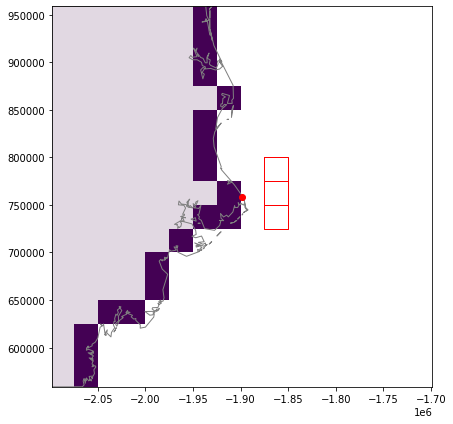

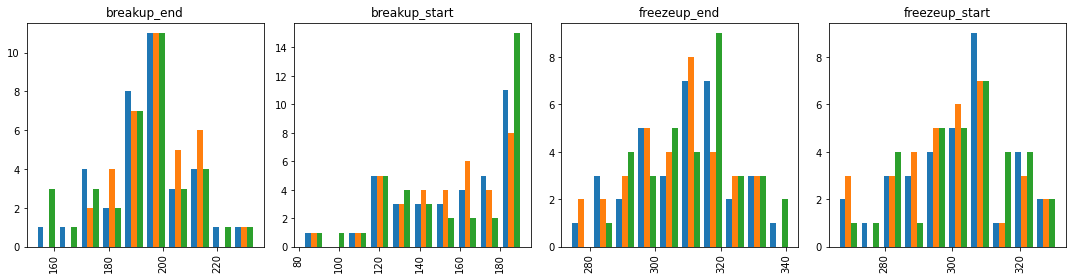

In [83]:
poi_name = "Utqiaġvik"
print("plotting points-of-interest...", file=terminal_output, flush=True)

kwargs = {
    "poi": (71.2906, -156.7886),
    "offsets": [(0, 1), (1, 1), (-1, 1)],
    "scale": 2,
    "seamask_src": seamask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name]))

print(f"{poi_name} done", file=terminal_output, flush=True)

### South Chukchi Sea

68.3478N, 166.8081W (Using coordinates for Point Hope, AK)

South Chukchi Sea done


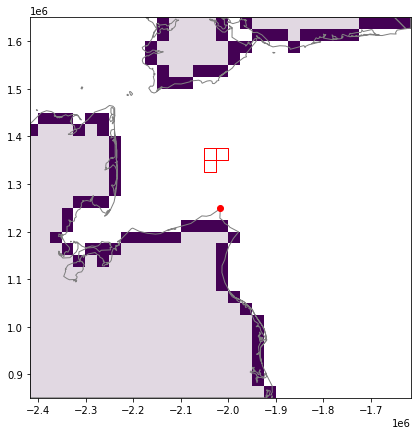

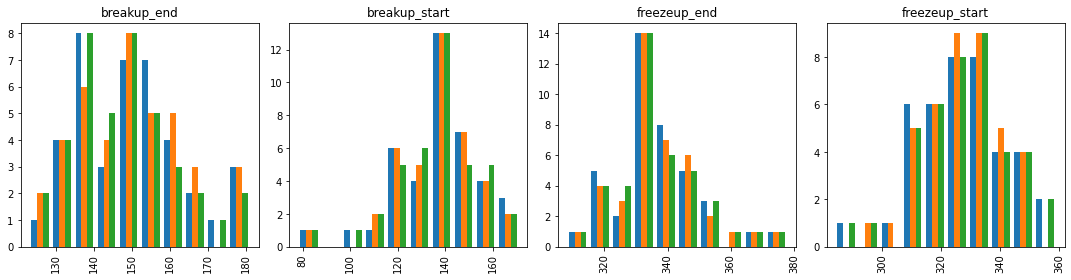

In [85]:
poi_name = "South Chukchi Sea"
kwargs = {
    "poi": (68.3478, -166.8081),
    "offsets": [(-4, 0), (-3, -1), (-4, -1)],
    "scale": 4,
    "seamask_src": seamask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name]))

print(f"{poi_name} done", file=terminal_output, flush=True)

### St. Lawrence Island

62.9N, 169.6W (Using point on south coast of the island) 

St. Lawrence Island done


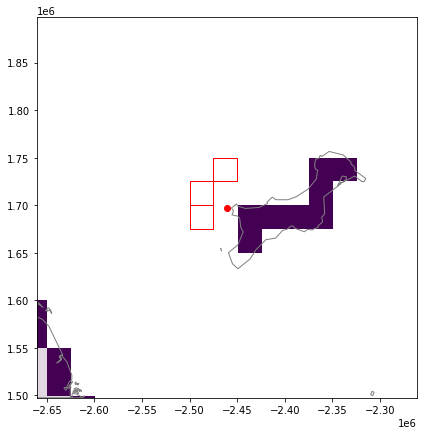

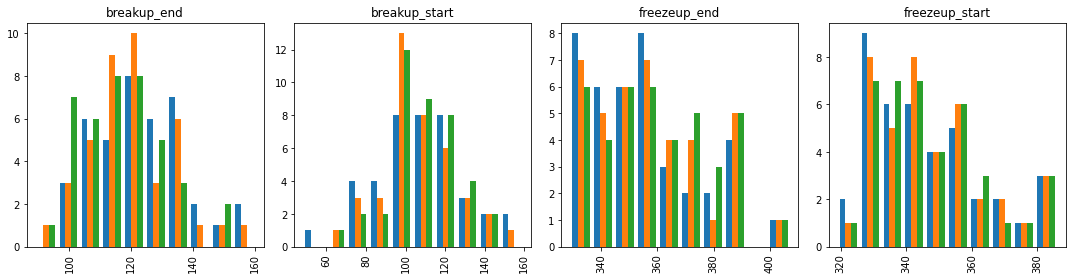

In [86]:
poi_name = "St. Lawrence Island"
kwargs = {
    "poi": (62.9, -169.6),
    "offsets": [(0, -1), (-1, -1), (-2, 0)],
    "scale": 2,
    "seamask_src": seamask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name]))

print(f"{poi_name} done", file=terminal_output, flush=True)

## New points of interest

### Beaufort Sea

Prudhoe Bay, 70.2N, 148.2W

**Note** - it's not really necessary to show the coastline antimask, because it appears to be consistent with the seamask created from the NSIDC-0747 dataset. The point is to demonstrate we've 

Prudhoe Bay done


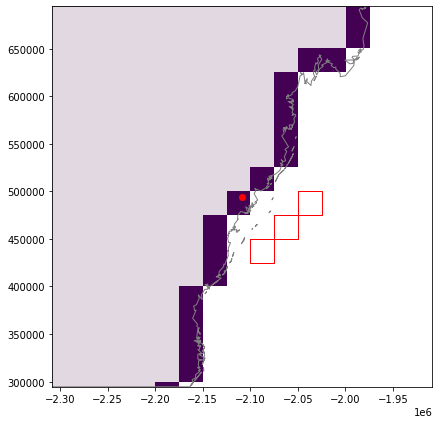

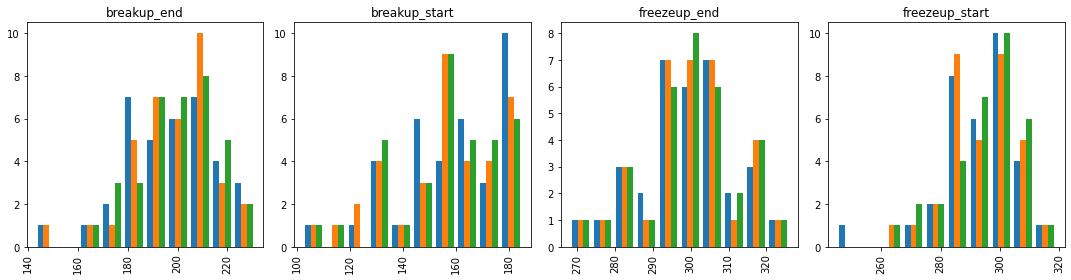

In [87]:
poi_name = "Prudhoe Bay"
kwargs = {
    "poi": (70.2, -148.2),
    "offsets": [(2, 1), (1, 2), (0, 3)],
    "scale": 2,
    "seamask_src": seamask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name]))

print(f"{poi_name} done", file=terminal_output, flush=True)

### East Siberian Sea
Pevek, 69.8N, 170.6E

Pevek done


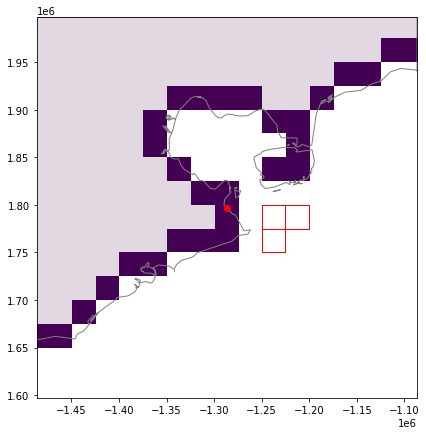

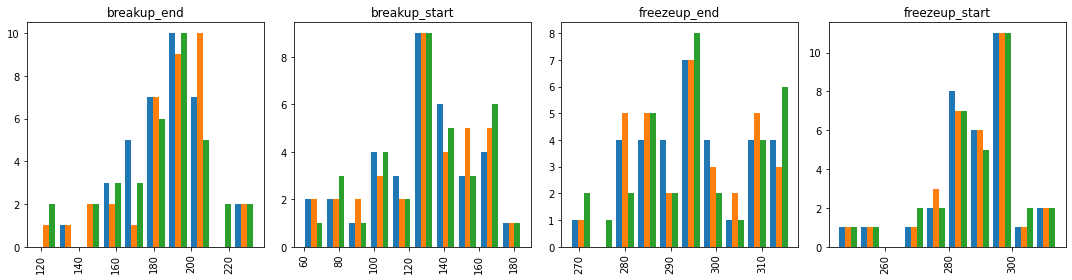

In [88]:
poi_name = "Pevek"
kwargs = {
    "poi": (69.8, 170.6),
    "offsets": [(0, 2), (0, 3), (1, 2)],
    "scale": 2,
    "seamask_src": seamask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name]))

print(f"{poi_name} done", file=terminal_output, flush=True)

### Laptev Sea
Tiksi, 71.7N, 126.9E

Tiksi done


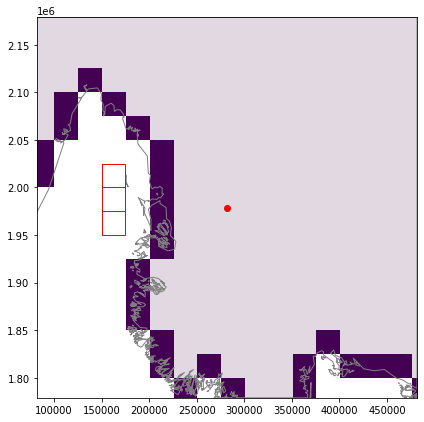

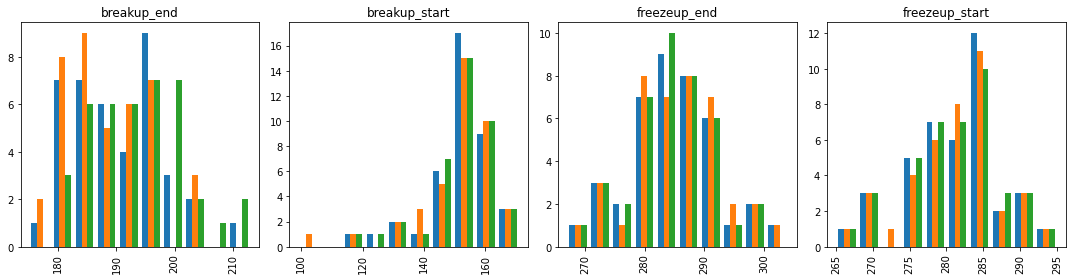

In [89]:
poi_name = "Tiksi"
kwargs = {
    "poi": (71.7, 126.9),
    "offsets": [(0, -5), (1, -5), (-1, -5)],
    "scale": 2,
    "seamask_src": seamask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name]))

print(f"{poi_name} done", file=terminal_output, flush=True)

### Kara Sea
Sabetta, 71.3N, 72.1E

Sabetta done


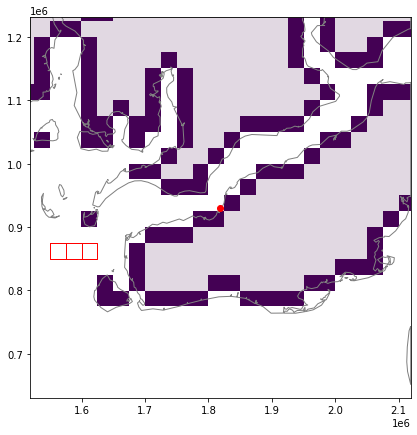

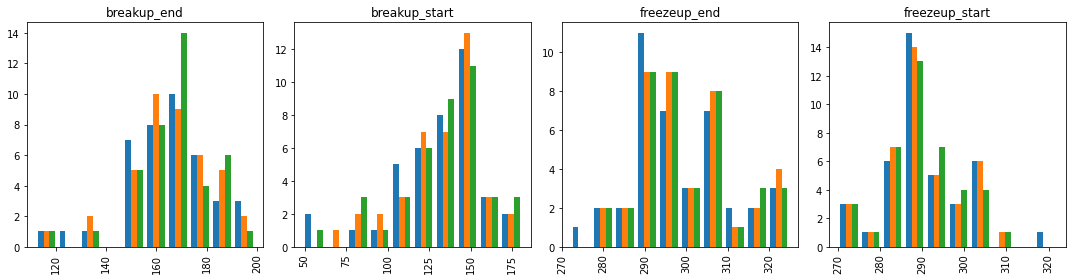

In [90]:
poi_name = "Sabetta"
kwargs = {
    "poi": (71.3, 72.1),
    "offsets": [(3, -10), (3, -9), (3, -8)],
    "scale": 3,
    "seamask_src": seamask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name]))

print(f"{poi_name} done", file=terminal_output, flush=True)

### Greenland Sea
Mestersvig, 72.2N, 23.9W

Mestersvig done


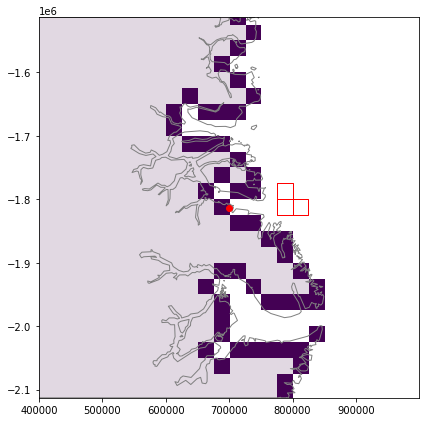

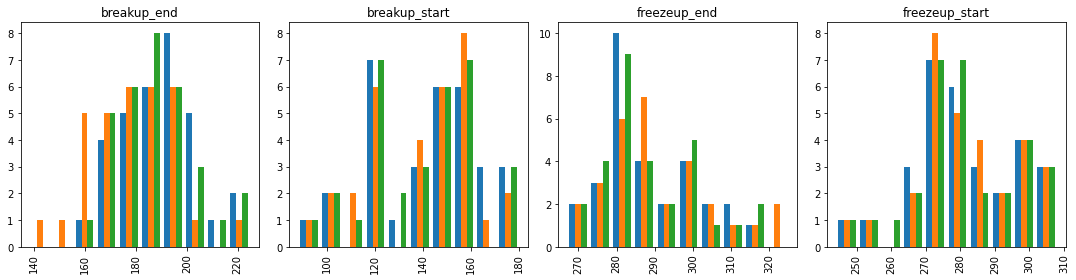

In [91]:
poi_name = "Mestersvig"
kwargs = {
    "poi": (72.2, -23.9),
    "offsets": [(0, 4), (0, 5), (-1, 4)],
    "scale": 3,
    "seamask_src": seamask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name]))

print(f"{poi_name} done", file=terminal_output, flush=True)

### Baffin Bay
Clyde River, 70.3N, 68.3W

Clyde River done


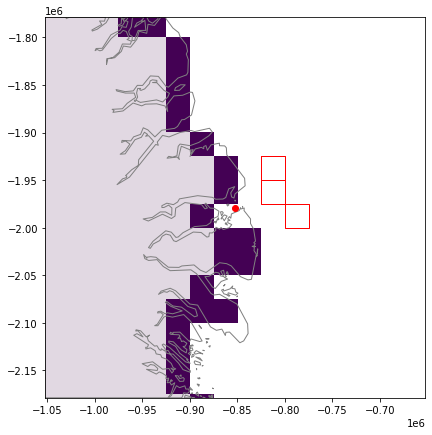

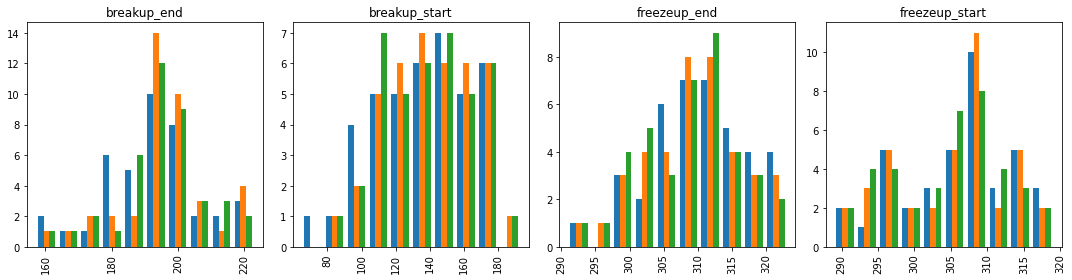

In [92]:
poi_name = "Clyde River"
kwargs = {
    "poi": (70.3, -68.3),
    "offsets": [(0, 3), (-1, 2), (-2, 2)],
    "scale": 2,
    "seamask_src": seamask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name]))

print(f"{poi_name} done", file=terminal_output, flush=True)

### Hudson Bay
Churchill, 58.8N, 94.2W

Churchill done


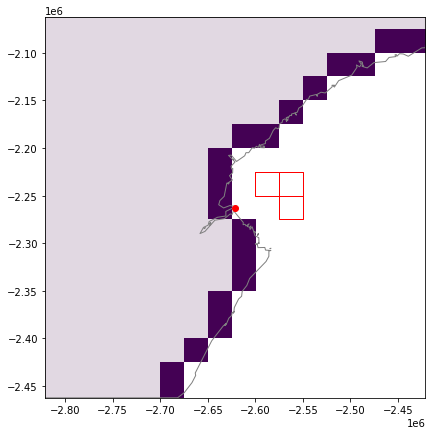

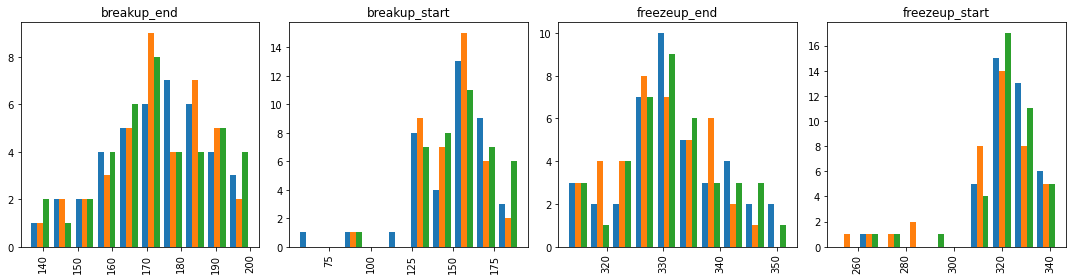

In [93]:
poi_name = "Churchill"
kwargs = {
    "poi": (58.8, -94.2),
    "offsets": [(0, 2), (-1, 1), (-1, 2)],
    "scale": 2,
    "seamask_src": seamask_src,
    "coast_src": coast_src,
    "world_shore": world_shore,
}

poi_coords[poi_name] = plot_poi_pixel_polys(**kwargs)

poi_indicators.append(plot_date_histograms(fubu, poi_coords[poi_name]))

print(f"{poi_name} done", file=terminal_output, flush=True)

Write the selected coordinates to the `$BASE_DIR/ancillary/points_of_interest.csv`.

In [28]:
import time
import datetime as dt

# rearrange dict for friendly DF
new_poi_coords = {
    "location": [],
    "x": [],
    "y": [],
}

for key in poi_coords:
    for point in poi_coords[key]:
        new_poi_coords["location"].append(key)
        new_poi_coords["x"].append(point[0])
        new_poi_coords["y"].append(point[1])

poi_fp = base_dir.joinpath("ancillary/points_of_interest.csv")
pd.DataFrame(new_poi_coords).to_csv(poi_fp, index=False)

print((
    f"Execution completed at {dt.datetime.utcfromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')}, "
    f"coordinates for points-of-interest written to {poi_fp}"), 
    file=terminal_output,
    flush=True
)

Write the extracted points-of-interest indicators to CSV files: `$BASE_DIR/ancillary/points_of_interest_<indicator>.csv`

In [104]:
temp_fp = base_dir.joinpath("ancillary/poi_{}_dates.csv")
for indicator in np.unique(poi_indicators_df.indicator):
    out_fp = str(temp_fp).format(indicator)
    poi_indicators_df.query(
        f"indicator == '{indicator}'"
    ).pivot(
        index="year", columns="location", values="mean_date"
    ).to_csv(out_fp, index=False)
    print(f"{indicator} dates for points of interest written to {out_fp}")

breakup_end dates for points of interest written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/poi_breakup_end_dates.csv
breakup_start dates for points of interest written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/poi_breakup_start_dates.csv
freezeup_end dates for points of interest written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/poi_freezeup_end_dates.csv
freezeup_start dates for points of interest written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/ancillary/poi_freezeup_start_dates.csv
